# 1. Testing loading high resolution outputs from IFS Cycle 3
# 2. Loading detected blocking and plotting masks

In [1]:
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import numpy as np
import matplotlib.pylab as plt
import xarray as xr

In [2]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )


In [3]:
def convert_to_xarray(ds,var,lev,date):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
    if lev=='sfc':
        sample = np.reshape(ds[var].values,(len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    else:
        sample = np.reshape(ds[var].sel(time=date,level=lev).values,(len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], np.unique(ds.lon)),
            # lat=(["lat"], np.unique(ds.lat)),
            lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
            ds[var].attrs,
        ),
    )
    
    
    return da



In [4]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [5]:
cat.IFS

IFS:
  args:
    path: https://raw.githubusercontent.com/nextGEMS/catalog/main/IFS/main.yaml
  description: IFS model output
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://data.nextgems-h2020.eu


In [6]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'IFS_4.4-FESOM_5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) # tco2559-ng5-cycle3 will soon be removed
#print(list(cat.IFS['IFS_9-NEMO_25-cycle3'])) # tco2559-ng5-cycle3 will soon be removed

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [7]:
data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['3D_1h6h_0.25deg'].to_dask() # load lower-resolution here, monthly means
#data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask() # load lower-resolution here, monthly means
#data = cat.IFS['IFS_9-NEMO_25-cycle3']['3D_1h6h_native'].to_dask() # load lower-resolution here, monthly means

In [8]:
#data

In [9]:
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array for regridded data
date='2023-02-13T18:00:00'
var1 = convert_to_xarray(data,var='q',lev=700.0,date=date)

In [10]:
var2 = convert_to_xarray(data,var='z',lev=500.0,date=date)
(var2*1000).max()

<xarray.DataArray 'z' ()>
array(58084877.9296875)

## Native grid must be interpolated as below!!!

In [9]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
#lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

In [10]:
#ax.set_ylim([45,48])
#ax.set_xlim([6,10.5])

#lon = np.linspace(10, 90, 90*10)
#lat = np.linspace(40, 80, (80-40)*10)
#lon2, lat2 = np.meshgrid(lon, lat)

#
lon = np.linspace(0, 360, 360*10)
lat = np.linspace(0, 90, (90-40)*10)
lon2, lat2 = np.meshgrid(lon, lat)

###factor=50
#lon = np.linspace(6, 11, 5*10)
#lat = np.linspace(45, 48, (48-45)*10)
#lon2, lat2 = np.meshgrid(lon, lat)




In [309]:
lon

array([0.00000000e+00, 1.00027785e-01, 2.00055571e-01, ...,
       3.59799944e+02, 3.59899972e+02, 3.60000000e+02])

In [11]:
#pcp=data.tp.sel(time=data.tp.time.dt.month.isin([7]))
#data =pcp.sel(time=pcp.time.dt.year.isin([2020]))
#data

In [12]:
#dsel_diff = pcp.diff('time')
##dsel_diff
#pcp = xr.where(dsel_diff > 0, dsel_diff, None)

In [13]:
#pcp_max=pcp[0:200,:].max(dim='time').compute()
#pcp_max=pcp[15,:]

In [317]:
#date='2023-02-13T12:00:00'
date='2023-02-09T12:00:00'
prs=700
data_sample = data['q'].sel(time=date,level=prs)

In [318]:
#data_sample

In [319]:


nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))


In [320]:
interpolated_nn

array([[3.89617571e-03, 3.89617571e-03, 3.92121432e-03, ...,
        4.06650809e-03, 4.06650809e-03, 4.06650809e-03],
       [3.93491314e-03, 3.93491314e-03, 3.88317631e-03, ...,
        4.01703996e-03, 4.01703996e-03, 4.01703996e-03],
       [3.93491314e-03, 3.93491314e-03, 3.88317631e-03, ...,
        4.01703996e-03, 4.01703996e-03, 4.01703996e-03],
       ...,
       [7.58839888e-05, 7.58839888e-05, 7.58839888e-05, ...,
        7.58839888e-05, 7.58839888e-05, 7.58839888e-05],
       [7.58839888e-05, 7.58839888e-05, 7.58839888e-05, ...,
        7.58839888e-05, 7.58839888e-05, 7.58839888e-05],
       [6.70019654e-05, 6.70019654e-05, 6.70019654e-05, ...,
        6.70019654e-05, 6.70019654e-05, 6.70019654e-05]])

In [321]:
#interpolated_nn
import xarray as xr
var1 =xr.DataArray(interpolated_nn,
                       coords={'lat':lat,'lon':lon},
                       dims=["lat","lon"]
                      )
var1

<xarray.DataArray (lat: 500, lon: 3600)>
array([[3.89617571e-03, 3.89617571e-03, 3.92121432e-03, ...,
        4.06650809e-03, 4.06650809e-03, 4.06650809e-03],
       [3.93491314e-03, 3.93491314e-03, 3.88317631e-03, ...,
        4.01703996e-03, 4.01703996e-03, 4.01703996e-03],
       [3.93491314e-03, 3.93491314e-03, 3.88317631e-03, ...,
        4.01703996e-03, 4.01703996e-03, 4.01703996e-03],
       ...,
       [7.58839888e-05, 7.58839888e-05, 7.58839888e-05, ...,
        7.58839888e-05, 7.58839888e-05, 7.58839888e-05],
       [7.58839888e-05, 7.58839888e-05, 7.58839888e-05, ...,
        7.58839888e-05, 7.58839888e-05, 7.58839888e-05],
       [6.70019654e-05, 6.70019654e-05, 6.70019654e-05, ...,
        6.70019654e-05, 6.70019654e-05, 6.70019654e-05]])
Coordinates:
  * lat      (lat) float64 0.0 0.1804 0.3607 0.5411 ... 89.46 89.64 89.82 90.0
  * lon      (lon) float64 0.0 0.1 0.2001 0.3001 ... 359.7 359.8 359.9 360.0

### Save new variable

In [322]:
prs=500
data_sample = data['z'].sel(time=date,level=prs)

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))


In [323]:
###interpolated_nn (kg m**-2)
import xarray as xr
var2 =xr.DataArray(interpolated_nn,
                       coords={'lat':lat,'lon':lon},
                       dims=["lat","lon"]
                      )
####tcsw.min()

In [324]:
var2.lon

<xarray.DataArray 'lon' (lon: 3600)>
array([0.000000e+00, 1.000278e-01, 2.000556e-01, ..., 3.597999e+02,
       3.599000e+02, 3.600000e+02])
Coordinates:
  * lon      (lon) float64 0.0 0.1 0.2001 0.3001 ... 359.7 359.8 359.9 360.0

In [325]:
#month = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_monthly_native'].to_dask() # load lower-resolution here, monthly means
#month

In [326]:
#month['2t'][0:2,:]

In [327]:
#month['2t']
#data_sample = month['2t'][0:2,:].mean(dim='time') 

#nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
#interpolated_nn = nn_interpolation((lon2, lat2))

In [328]:
#t2m =xr.DataArray(interpolated_nn,
#                       coords={'lat':lat,'lon':lon},
#                       dims=["lat","lon"]
#                      )
#t2m

In [329]:
#t2-t2m

## Load detected blockings with contrack

In [13]:
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full.nc')
#full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_v3.nc')
full_ifs = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_0.8.nc')

In [14]:
full_ifs.flag[100,:,:].max()

<xarray.DataArray 'flag' ()>
array(48, dtype=int32)
Coordinates:
    time     datetime64[ns] 2020-02-14T06:00:00

In [17]:
import pandas as pd
#block_df =  pd.read_csv('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_v3.csv', delimiter=',',header=0)
block_df =  pd.read_csv('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs_4.4-fesom_5_full_0.8.csv', delimiter=',',header=0)
#block_df.loc[block_df['Flag']==3345] #3345
#bid=3345  #date='2023-02-13T18:00:00' / 20230213_18
bid=4245

mdate = date[0:4] + date[5:7] + date[8:10] + '_' + date[11:13]
lons = np.asarray(block_df['Longitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])
lats = np.asarray(block_df['Latitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])
mdate


'20230213_18'

In [18]:
#full_ifs.flag.sel(time=date).max()

In [19]:
flevels=[3044.5, 3045.5] ### flag
#flevels=[3045,3046] ### flag
#flevels=[3136, 3137, 3138] ### flag

<Figure size 2100x900 with 0 Axes>

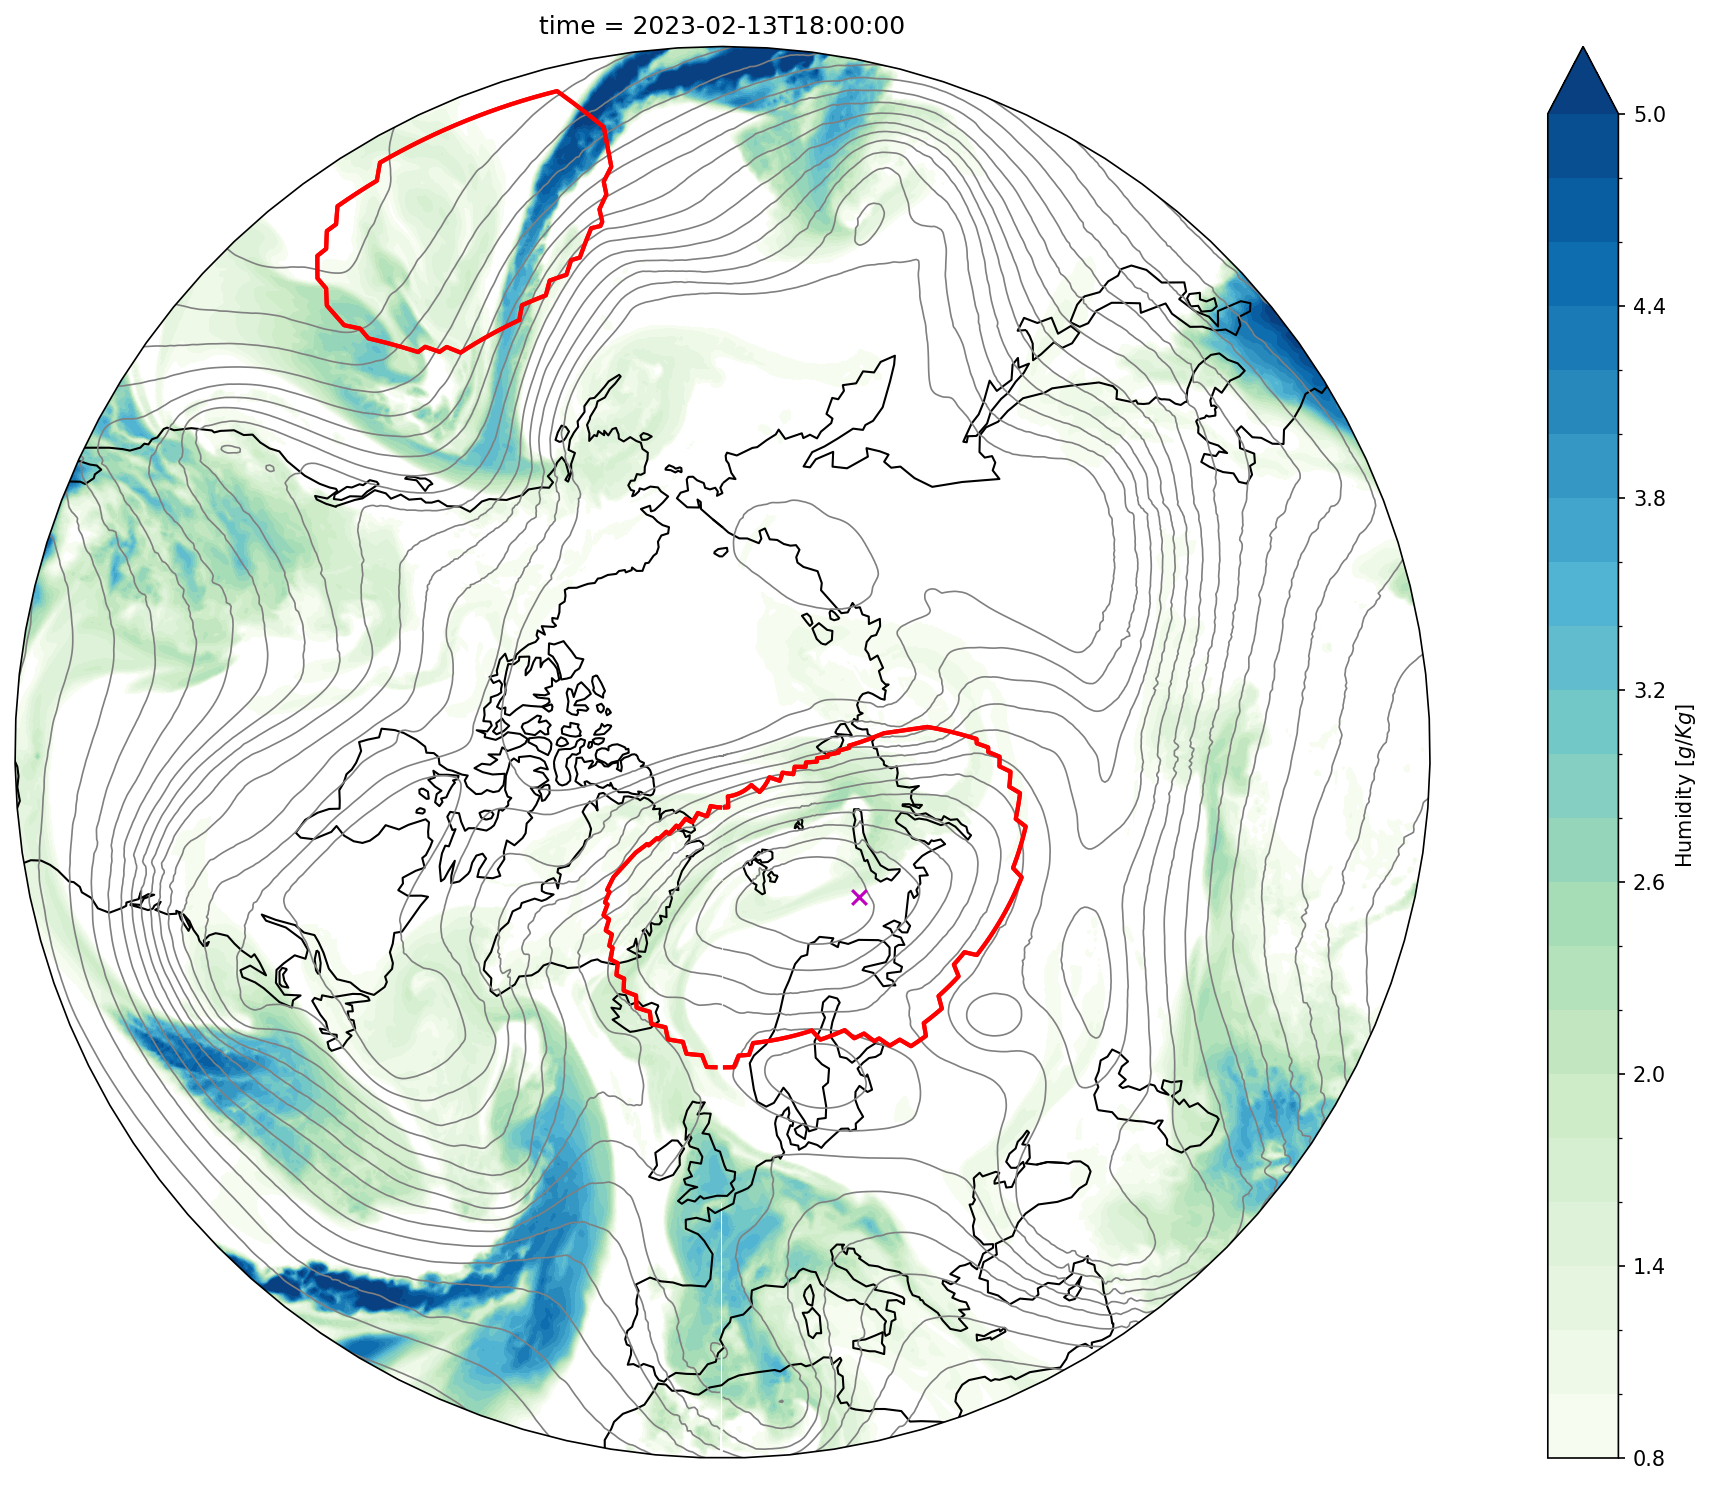

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.patches as mpatches
import matplotlib.path as mpath

plt.figure(figsize=(14,6),dpi=150)
fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
#ax=plt.axes(projection=ccrs.PlateCarree())

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

(var1*1000).plot.contourf(ax=ax, levels=np.arange(0.8,5.2,0.2), cmap='GnBu',extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'Humidity [$g/Kg$]'})
#(temp-273).plot.contourf(ax=ax, levels=np.arange(-20,30,2), cmap='twilight',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'SLP[$hPa$]'})
(var2).plot.contour(ax=ax, levels=np.arange(50000,60000,500), colors='grey',linewidths=0.8, transform=ccrs.PlateCarree())

#(tcsw).plot.contourf(ax=ax, levels=np.arange(0,2.5,0.5), cmap='twilight',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'P[$hPa$]'})


###Blockings
im1=full_ifs.flag.sel(time=date).plot.contour(ax=ax,levels=flevels,colors='r',linewidths=2,extend = 'neither', transform=ccrs.PlateCarree())
#im1=full_ifs.flag.sel(time=date).plot.contourf(ax=ax,levels=flevels,cmap='Greys_r', extend='neither', transform=ccrs.PlateCarree(), alpha=0.2,add_colorbar=False)
#im1=full_ifs.flag.sel(time=date).plot.contourf(ax=ax,levels=flevels,cmap='Greys_r',zorder=9, extend='neither', transform=ccrs.PlateCarree(), alpha=0.5,add_colorbar=True)
#ax.add_feature(cf.BORDERS)

ax.scatter(lons[0],lats[0],s=50,c='m',marker="x", zorder=10, transform=ccrs.PlateCarree())
    
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 
ax.coastlines()
plt.tight_layout()

###=== Add colorbar
#cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])  # Left, bottom, width, height.
#cbar = fig.colorbar(im1, cax=cbar_ax, extend='both', orientation='horizontal')
#cbar.set_label(' Blocking (%)')

### Save
#plt.savefig('/home/b/b382006/figures/humidity_block_ifs_4.4-fesom_5-'+date+'.jpg')

In [21]:
### Do a loop
### test plot
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.patches as mpatches
import xarray as xr
import matplotlib.path as mpath

In [146]:
### interpolated grid
for i in range(3,19):
    ###date='2023-02-13T18:00:00'
    date='2023-02-'+str(i).zfill(2)+'T12:00:00'
    mdate = date[0:4] + date[5:7] + date[8:10] + '_' + date[11:13]
    print(date, mdate)
    
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array for regridded data
    var1 = convert_to_xarray(data,var='q',lev=700.0,date=date)
    var2 = convert_to_xarray(data,var='z',lev=500.0,date=date)

    lons = np.asarray(block_df['Longitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])
    lats = np.asarray(block_df['Latitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])    
    
####tcsw.min()


    plt.figure(figsize=(14,6),dpi=150)
    fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    (var1*1000).plot.contourf(ax=ax, levels=np.arange(0.8,5.2,0.2), cmap='GnBu',extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'Humidity [$g/Kg$]'})
#(temp-273).plot.contourf(ax=ax, levels=np.arange(-20,30,2), cmap='twilight',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'SLP[$hPa$]'})
    (var2).plot.contour(ax=ax, levels=np.arange(50000,60000,500), colors='grey',linewidths=0.8, transform=ccrs.PlateCarree())


    im1=full_ifs.flag.sel(time=date).plot.contour(ax=ax,levels=flevels,colors='r',linewidths=2,extend = 'neither', transform=ccrs.PlateCarree())
#    im1=full_ifs.flag.sel(time=date).plot.contourf(ax=ax,levels=flevels,cmap='Greys_r', extend='neither', transform=ccrs.PlateCarree(), alpha=0.2,add_colorbar=False)

    ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 

#    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())
    ax.scatter(lons[0],lats[0],s=50,c='m',marker="x", zorder=10, transform=ccrs.PlateCarree())
    
    ax.coastlines()

    plt.tight_layout()

### Save
    plt.savefig('/home/b/b382006/figures/humidity_block_ifs_4.4-fesom_5-'+date+'.jpg')
    plt.close()

2023-02-03T12:00:00 20230203_12
2023-02-04T12:00:00 20230204_12
2023-02-05T12:00:00 20230205_12
2023-02-06T12:00:00 20230206_12
2023-02-07T12:00:00 20230207_12
2023-02-08T12:00:00 20230208_12
2023-02-09T12:00:00 20230209_12
2023-02-10T12:00:00 20230210_12
2023-02-11T12:00:00 20230211_12
2023-02-12T12:00:00 20230212_12
2023-02-13T12:00:00 20230213_12
2023-02-14T12:00:00 20230214_12
2023-02-15T12:00:00 20230215_12
2023-02-16T12:00:00 20230216_12
2023-02-17T12:00:00 20230217_12
2023-02-18T12:00:00 20230218_12


<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

In [112]:
###  Native grid

In [ ]:
#plt.figure(figsize=(15,15))
#plt.imshow(np.flipud(interpolated_nn))


for i in range(1,20):
    ###date='2023-02-13T12:00:00'
    date='2023-02-'+str(i).zfill(2)+'T12:00:00'
    print(date)


###native grid
    prs=700
    data_sample = data['q'].sel(time=date,level=prs)
    nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
    interpolated_nn = nn_interpolation((lon2, lat2))

#interpolated_nn

    var1 =xr.DataArray(interpolated_nn,
                       coords={'lat':lat,'lon':lon},
                       dims=["lat","lon"]
                      )

    prs=500
    data_sample = data['z'].sel(time=date,level=prs)

    nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
    interpolated_nn = nn_interpolation((lon2, lat2))

    var2 =xr.DataArray(interpolated_nn,
                       coords={'lat':lat,'lon':lon},
                       dims=["lat","lon"]
                      )
    
#    mdate = date[0:4] + date[5:7] + date[8:10] + '_' + date[11:13]
#    lons = np.asarray(block_df['Longitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])
#    lats = np.asarray(block_df['Latitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])    
    
####tcsw.min()


    plt.figure(figsize=(14,6),dpi=150)
    fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    (var1*1000).plot.contourf(ax=ax, levels=np.arange(0.8,5.2,0.2), cmap='GnBu',extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'Humidity [$g/Kg$]'})
#(temp-273).plot.contourf(ax=ax, levels=np.arange(-20,30,2), cmap='twilight',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'SLP[$hPa$]'})
    (var2).plot.contour(ax=ax, levels=np.arange(50000,60000,500), colors='grey',linewidths=0.8, transform=ccrs.PlateCarree())


#    im1=full_ifs.flag.sel(time=date).plot.contour(ax=ax,levels=flevels,cmap='Paired',linewidths=2, transform=ccrs.PlateCarree())
    im1=full_ifs.flag.sel(time=date).plot.contourf(ax=ax,levels=flevels,cmap='Greys_r', extend='neither', transform=ccrs.PlateCarree(), alpha=0.2,add_colorbar=False)
#ax.add_feature(cf.BORDERS)
#ax.add_feature(cf.BORDERS)
#ax.add_feature(cf.LAKES)
#ax.add_feature(cf.RIVERS)
#ax.set_ylim([40,90])
#ax.set_xlim([0,90])
#ax.gridlines(draw_labels=True)
#cbar=im1.colorbar(trend, size='3%',ticks=bounds,extend="max",location="bottom")
#cbar=im1.colorbar(location="bottom")
    ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 

#    ax.set_ylabel('($^o$C)')
    
    ax.coastlines()

    plt.tight_layout()

###=== Add colorbar
#cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])  # Left, bottom, width, height.
#cbar = fig.colorbar(im1, cax=cbar_ax, extend='both', orientation='horizontal')
#cbar.set_label(' Blocking (%)')

### Save
    plt.savefig('/home/b/b382006/figures/humidity_block_ifs_4.4-fesom_5-'+date+'.jpg')
    plt.close()